### Full worklflow of employing CrystaLLM 2.0 for materials discovery

In [3]:
import __init__ # this just ensures were in the right env
from pymatgen.io.jarvis import JarvisAtomsAdaptor as JAA
from jarvis.core.atoms import Atoms
from pymatgen.io.cif import CifWriter
import json
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

### Step 1. Make the dataset in an apropriate format
- Data source
  - 1 json file that contains materials project material ids and their associated pmg structure objects
  - 1 json file that has the material ids and associated SLMEs
  > In the field of photovoltaics (PVs), SLME stands for Spectroscopic Limited Maximum Efficiency. It's a theoretical metric used to predict the maximum possible energy conversion efficiency of a solar cell material. Its more detailed and material-specific than the widely used Shockley-Queisser limit. See [this paper](https://arxiv.org/pdf/2507.13246) for more details on ML and SLMEs

- Columns we want to finetune CrystaLLM 2.0
  - We want to condition generation on SLME, to try and find novel materials with high SLMEs
  - 'Material ID': unique identifier, here for traceability of training data
  - 'Reduced Formula': This will be used to speed up novelty metric calculations
  - 'CIF': text sequences that the language model will train on
  - 'SLME': the property that the model will condition its sequence generation on

#### Lets build the dataset

In [2]:
def _symmetrize_cif(struct):
    """Convert structure to symmetrized CIF format with error handling."""
    sga = SpacegroupAnalyzer(struct)
    symm_struct = sga.get_symmetrized_structure()
    return str(CifWriter(symm_struct, symprec=0.1))
def structure_to_cif(struct):
    """Convert a pymatgen Structure to CIF format, attempting symmetrization first."""
    cif_str = _symmetrize_cif(struct)
    return cif_str
def extract_formula(struct):
    """Extract the reduced formula from a pymatgen Structure."""
    return struct.composition.reduced_formula

In [ ]:
with open('HF-databases/mpdb-slme/all_structures.json','r') as f:
    structure_dict = json.load(f)
with open('HF-databases/mpdb-slme/All_corr_SLMEs.json','r') as f:
    slme_dict = json.load(f)

df = pd.DataFrame(columns=['Material ID', 'Reduced Formula', 'CIF'])
for material_id, struct_dict in tqdm(structure_dict.items()):
    ats = Atoms.from_dict(struct_dict)
    structure = JAA.get_structure(ats)
    cif_str = structure_to_cif(structure)
    formula = extract_formula(structure)
    df = pd.concat([df, pd.DataFrame({'Material ID': [material_id], 'Reduced Formula': [formula], 'CIF': [cif_str]})], ignore_index=True)
    df['SLME'] = df['Material ID'].map(slme_dict)

df.to_parquet('HF-databases/mpdb-slme/mpdb-slme.parquet', index=False)

100%|██████████| 5346/5346 [01:09<00:00, 76.43it/s] 


#### We can visualise the distribution of SLMEs in the finetuning set 

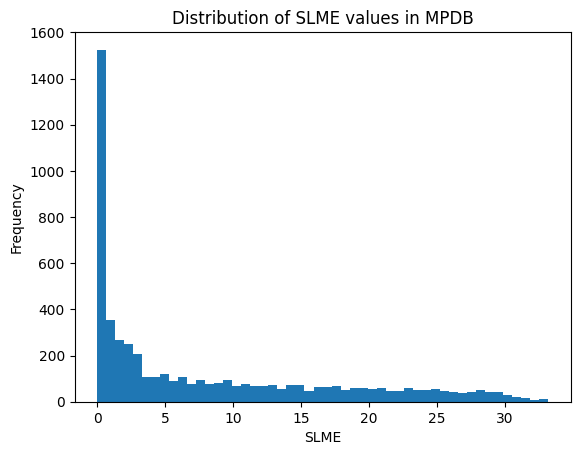

In [ ]:
plt.hist(df['SLME'].dropna(), bins=50)
plt.xlabel('SLME')
plt.ylabel('Frequency')
plt.title('Distribution of SLME values in MPDB')
plt.show()

#### Clean and augment the CIFs
- We turn the CIFs from standard into the correct format for CrystaLLM 2.0 training (process is invertible)
- We normalise the property we train on to stabilise training
- We also filtered so no augmented CIFs exceed context length (but none did so can skip)
> Note: We don't deduplicate because the dataset is already curated and each structure has different SLMEs so they are of interest for training. If you want to do this, see the [README.md](README.md)

In [ ]:
!python _utils/_preprocessing/_cleaning.py \
    --input_parquet HF-databases/mpdb-slme/mpdb-slme.parquet \
    --output_parquet HF-databases/mpdb-slme/mpdb-slme_clean_filtered.parquet \
    --property_columns "['SLME']" \
    --property1_normaliser "linear" \
    --num_workers 8 \
    --filter_to 1024

Loading data from HF-databases/mpdb-slme/mpdb-slme.parquet as Parquet with zstd compression...

Normalizing property columns

Normalizing with linear method for SLME...
Min value of SLME: 0.0
Min value of SLME after hardcoding: 0
Max value of SLME: 33.192
Max value of linear SLME: 1.0
Min value of linear SLME: 0.0

Lets augment the CIFs now (parallelizing sometimes takes a min before speeding up
Number of CIFs before preprocessing: 5346
Number of workers: 8
100%|█████████████████████████████████████| 5346/5346 [00:01<00:00, 4405.59it/s]
Number of CIFs before filtering out bad ones:  5346
Number of CIFs after filtering: 5346

Saving updated dataframe to HF-databases/mpdb-slme/mpdb-slme_clean.parquet as Parquet with zstd compression...
Preprocessing completed successfully.


### Save to HF
- Because we have a small dataset, we would like to train on all of it
- Datasets available on HuggingFace:
  - c-bone/mpdb-slme-full (100% - train)

In [4]:
!python _utils/_preprocessing/_save_dataset_to_HF.py \
    --input_parquet 'HF-databases/mpdb-slme/mpdb-slme_clean_filtered.parquet' \
    --output_parquet 'HF-databases/mpdb-slme/mpdb-slme-full.parquet' \
    --valid_size 0.00 \
    --test_size 0.00 \
    --save_hub

Loading Hugging Face API key from API_keys.jsonc
Loading data from HF-databases/mpdb-slme/mpdb-slme_clean_filtered.parquet as Parquet with zstd compression
Uploading the dataset shards: 100%|███████████████| 1/1 [00:01<00:00,  1.02s/it]
Dataset saved to Hugging Face Hub as c-bone/mpdb-slme-full


### Train the model
- I performed a quick hyperparameter search using a the same dataset but with a small validation set, best params stored in the config

In [ ]:
!torchrun --nproc_per_node=2 _train.py --config '_config_files/training/conditional/ft-slme/slme_ft-PKV-opt.jsonc'

#### Make Prompts
- Here the prompts are quite simple, we target any composition but the highest possible SLME

In [ ]:
!python _utils/_generating/make_prompts.py \
    --manual \
    --compositions "" \
    --condition_lists "1.0" \
    --output_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_prompt.parquet'


Generated manual prompts for 1 compositions and 1 condition lists

First 3 rows:
       Prompt condition_vector
<bos>\ndata_[              1.0

Saved 1 prompts to _utils/_evaluation_files/conditional_studies/slme/slme_prompt.parquet


#### Materials Generation
- With default params that balance exploration and exploitation of learned patterns

In [ ]:
!python _utils/_generating/generate_CIFs.py --config '_config_files/generation/conditional/slme/slme-PKV-opt_eval.jsonc'

#### Metrics
- We want to flag materials that are valid, unique, novel, and predicted stable for further analysis
- We can screen this pretty fast with the metrics scripts set up

In [ ]:
!python _utils/_metrics/VUN_metrics.py \
    --input_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_gen.parquet' \
    --huggingface_dataset 'c-bone/mpdb-slme-full' \
    --load_processed_data 'HF-databases/mpdb-slme/mpdb-slme-full_proc.parquet' \
    --output_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_post.parquet' \
    --num_workers 32

In [ ]:
!python _utils/_metrics/mace_ehull.py \
    --post_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_post.parquet' \
    --output_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_post-s.parquet' \
    --mp_data 'mp_computed_structure_entries.json.gz' \
    --num_workers 16

In [ ]:
import __init__
import pandas as pd
df = pd.read_parquet('_artifacts/slme/slme-PKV-opt_post-s.parquet')

valid_count = df['is_valid'].sum()
valid_unique_count = df[(df['is_valid']) & (df['is_unique'])].shape[0]
valid_unique_novel_count = df[(df['is_valid']) & (df['is_unique']) & (df['is_novel'])].shape[0]
low_ehull_count = df[(df['is_valid']) & (df['is_unique']) & (df['is_novel']) & (df['ehull_mace_mp'] < 0.1)].shape[0]
print(f"Valid entries: {valid_count}")
print(f"Valid and unique entries: {valid_unique_count}")
print(f"Valid, unique, and novel entries: {valid_unique_novel_count}")
print(f"Valid, unique, novel entries with ehull_mace_mp < 0.1: {low_ehull_count}")
print(f"Total entries: {len(df)}")

Valid entries: 83367
Valid and unique entries: 75252
Valid, unique, and novel entries: 73962
Valid, unique, novel entries with ehull_mace_mp < 0.1: 16463
Total entries: 100000


#### Surrogate Model Screening
- The valid, unique, novel entries were screened using an ALIGNN model trained on Hybrid bandgaps to look at the output materials
- They were also screened using an ALIGNN model that was trained on SLME data

In [25]:
# Create scatter plot with training distribution margins to show out-of-distribution generation
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import __init__
import pandas as pd


gen_merged = pd.read_parquet('HF-databases/mpdb-slme/mpdb-slme_surrogate_metrics.parquet')

# Load training distributions
training_hse_gaps = pd.read_json('HF-databases/mpdb-slme/MPID_Kim_HSE_gaps.json', typ='series')
training_slmes = pd.read_json('HF-databases/mpdb-slme/All_corr_SLMEs.json', typ='series')

In [6]:
fgw_dists_0 = pd.read_csv('HF-databases/mpdb-slme/crystaLLM_candidates/crysFGW_0.00_cosine.csv')
fgw_dists_05 = pd.read_csv('HF-databases/mpdb-slme/crystaLLM_candidates/crysFGW_0.50_cosine.csv')
fgw_dists_10 = pd.read_csv('HF-databases/mpdb-slme/crystaLLM_candidates/crysFGW_1.00_cosine.csv')


In [27]:
# for each row, take the average of all the values for that row except for the column where the string in "Unnamed:0" column matches the column (comparing againbst itself for a symmetric matrix)

# Exclude the diagonal (self-comparison) for each row
material_names = fgw_dists_10['Unnamed: 0']
avg_scores = []

for idx, row in fgw_dists_10.iterrows():
    name = row['Unnamed: 0']
    # Get all columns except the one matching the material name
    scores = row.drop(labels=['Unnamed: 0'])
    # Remove self-comparison (column matching the material name)
    if name in scores.index:
        scores = scores.drop(labels=name)
    avg_score = scores.mean()
    avg_scores.append(avg_score)

avg_df_10 = pd.DataFrame({
    'material_id': material_names,
    'avg_crysFGW_1.00_cosine': avg_scores
})

In [29]:
# for each 
avg_df_10['material_id'] = avg_df_10['material_id'].astype(str)
avg_df_10['material_id'] = avg_df_10['material_id'].str.replace('Generated_', '')
avg_df_10['material_id'] = avg_df_10['material_id'].astype(int)
avg_df_10


,material_id,avg_crysFGW_1.00_cosine
0,5,0.156549
1,7,0.207699
2,19,0.153156
3,20,0.817246
4,33,0.167390
...,...,...
16458,99965,0.214812
16459,99969,0.171166
16460,99975,0.156295
16461,99978,0.239695


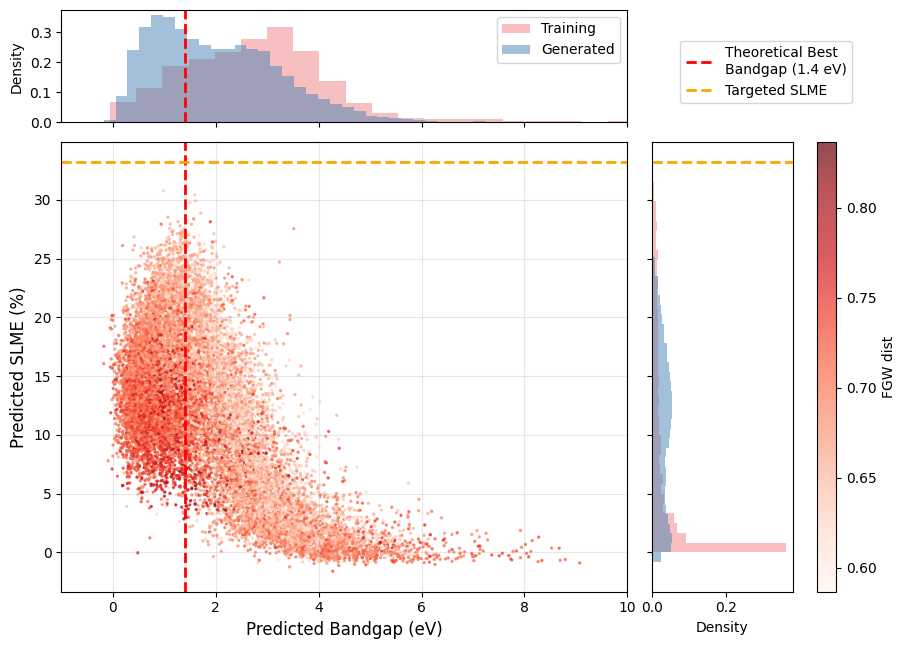

In [10]:

# Create figure with GridSpec for marginal plots with tighter spacing
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, height_ratios=[0.75, 3, 0.1], width_ratios=[3, 0.75, 0.1], 
              hspace=0.1, wspace=0.1)

# Main scatter plot
ax_main = fig.add_subplot(gs[1, 0])
scatter = ax_main.scatter(gen_merged['predicted_gap'], gen_merged['predicted_slme'], 
                         c=gen_merged['avg_crysFGW_0.00_cosine'], cmap='Reds', alpha=0.7, s=2)

# Reference lines
line1 = ax_main.axvline(x=1.4, color='r', linestyle='--', linewidth=2, label='Theoretical Best Bandgap (1.4 eV)')
line2 = ax_main.axhline(y=33.2, color='orange', linestyle='--', linewidth=2, label='Target SLME')

ax_main.set_xlabel('Predicted Bandgap (eV)', fontsize=12)
ax_main.set_ylabel('Predicted SLME (%)', fontsize=12)
ax_main.set_xlim(-1, 10)
ax_main.grid(True, alpha=0.3)

# Top histogram (bandgap)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_top.hist(training_hse_gaps.values, bins=40, alpha=0.5, color='lightcoral', 
           density=True, label='Training')
ax_top.hist(gen_merged['predicted_gap'], bins=40, alpha=0.5, color='steelblue', 
           density=True, label='Generated')
ax_top.axvline(x=1.4, color='r', linestyle='--', linewidth=2, alpha=1.0)
ax_top.set_ylabel('Density', fontsize=10)
ax_top.legend(fontsize=10)
plt.setp(ax_top.get_xticklabels(), visible=False)

# Right histogram (SLME)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_right.hist(training_slmes.values, bins=40, alpha=0.5, color='lightcoral', 
             density=True, orientation='horizontal', label='Training')
ax_right.hist(gen_merged['predicted_slme'], bins=40, alpha=0.5, color='steelblue', 
             density=True, orientation='horizontal', label='Generated')
ax_right.axhline(y=33.2, color='orange', linestyle='--', linewidth=2, alpha=1.0)
ax_right.set_xlabel('Density', fontsize=10)
plt.setp(ax_right.get_yticklabels(), visible=False)

# Colorbar
ax_cbar = fig.add_subplot(gs[1, 2])
cbar = plt.colorbar(scatter, cax=ax_cbar)
cbar.set_label('FGW dist', fontsize=10)

# Add legend outside the plot area
fig.legend([line1, line2], ['Theoretical Best \nBandgap (1.4 eV)', 'Targeted SLME'], 
           loc='upper center', bbox_to_anchor=(0.83, 0.85), ncol=1, fontsize=10)

plt.tight_layout
plt.show()

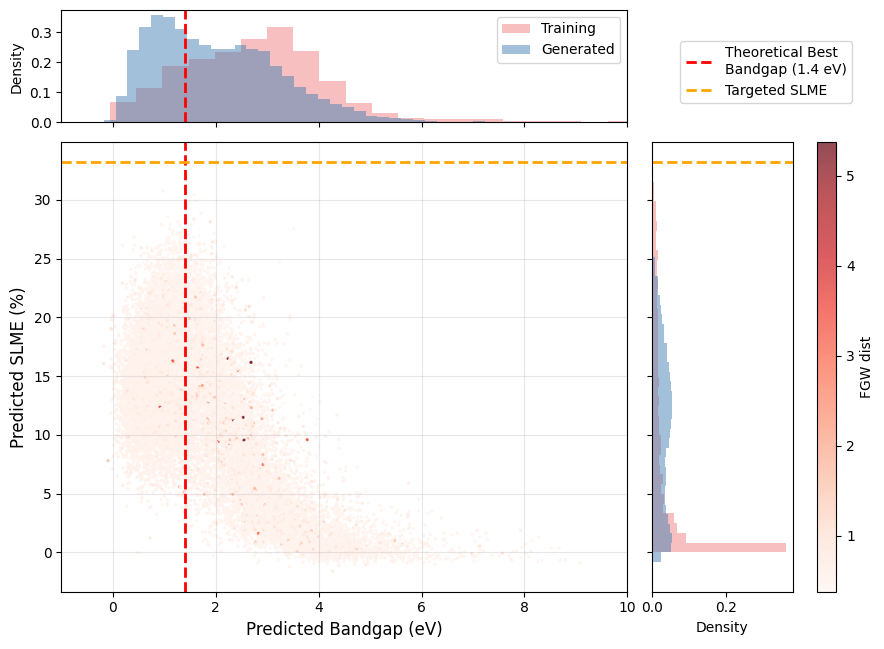

In [11]:

# Create figure with GridSpec for marginal plots with tighter spacing
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, height_ratios=[0.75, 3, 0.1], width_ratios=[3, 0.75, 0.1], 
              hspace=0.1, wspace=0.1)

# Main scatter plot
ax_main = fig.add_subplot(gs[1, 0])
scatter = ax_main.scatter(gen_merged['predicted_gap'], gen_merged['predicted_slme'], 
                         c=gen_merged['avg_crysFGW_0.50_cosine'], cmap='Reds', alpha=0.7, s=2)

# Reference lines
line1 = ax_main.axvline(x=1.4, color='r', linestyle='--', linewidth=2, label='Theoretical Best Bandgap (1.4 eV)')
line2 = ax_main.axhline(y=33.2, color='orange', linestyle='--', linewidth=2, label='Target SLME')

ax_main.set_xlabel('Predicted Bandgap (eV)', fontsize=12)
ax_main.set_ylabel('Predicted SLME (%)', fontsize=12)
ax_main.set_xlim(-1, 10)
ax_main.grid(True, alpha=0.3)

# Top histogram (bandgap)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_top.hist(training_hse_gaps.values, bins=40, alpha=0.5, color='lightcoral', 
           density=True, label='Training')
ax_top.hist(gen_merged['predicted_gap'], bins=40, alpha=0.5, color='steelblue', 
           density=True, label='Generated')
ax_top.axvline(x=1.4, color='r', linestyle='--', linewidth=2, alpha=1.0)
ax_top.set_ylabel('Density', fontsize=10)
ax_top.legend(fontsize=10)
plt.setp(ax_top.get_xticklabels(), visible=False)

# Right histogram (SLME)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_right.hist(training_slmes.values, bins=40, alpha=0.5, color='lightcoral', 
             density=True, orientation='horizontal', label='Training')
ax_right.hist(gen_merged['predicted_slme'], bins=40, alpha=0.5, color='steelblue', 
             density=True, orientation='horizontal', label='Generated')
ax_right.axhline(y=33.2, color='orange', linestyle='--', linewidth=2, alpha=1.0)
ax_right.set_xlabel('Density', fontsize=10)
plt.setp(ax_right.get_yticklabels(), visible=False)

# Colorbar
ax_cbar = fig.add_subplot(gs[1, 2])
cbar = plt.colorbar(scatter, cax=ax_cbar)
cbar.set_label('FGW dist', fontsize=10)

# Add legend outside the plot area
fig.legend([line1, line2], ['Theoretical Best \nBandgap (1.4 eV)', 'Targeted SLME'], 
           loc='upper center', bbox_to_anchor=(0.83, 0.85), ncol=1, fontsize=10)

plt.tight_layout
plt.show()

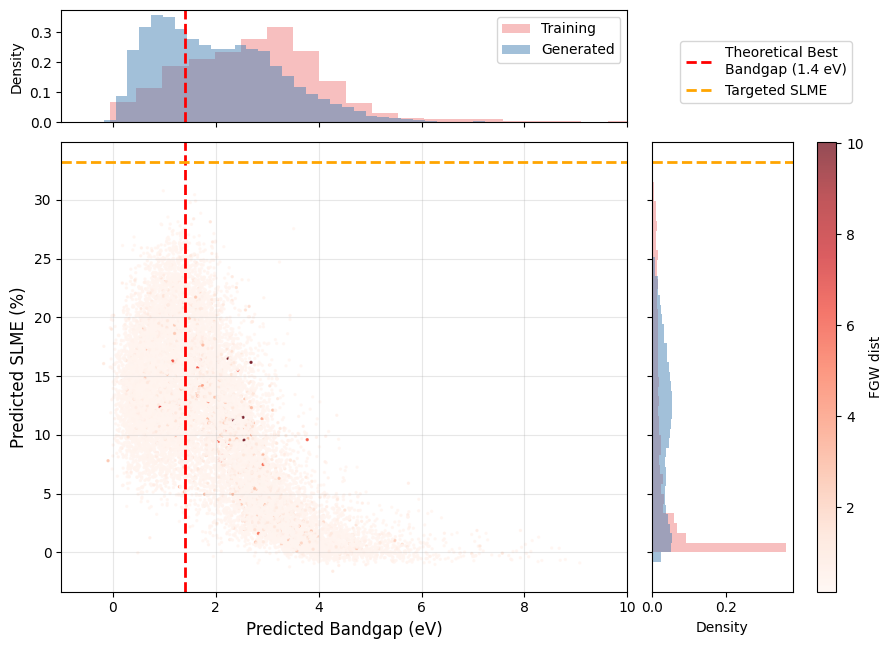

In [12]:

# Create figure with GridSpec for marginal plots with tighter spacing
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, height_ratios=[0.75, 3, 0.1], width_ratios=[3, 0.75, 0.1], 
              hspace=0.1, wspace=0.1)

# Main scatter plot
ax_main = fig.add_subplot(gs[1, 0])
scatter = ax_main.scatter(gen_merged['predicted_gap'], gen_merged['predicted_slme'], 
                         c=gen_merged['avg_crysFGW_1.00_cosine'], cmap='Reds', alpha=0.7, s=2)

# Reference lines
line1 = ax_main.axvline(x=1.4, color='r', linestyle='--', linewidth=2, label='Theoretical Best Bandgap (1.4 eV)')
line2 = ax_main.axhline(y=33.2, color='orange', linestyle='--', linewidth=2, label='Target SLME')

ax_main.set_xlabel('Predicted Bandgap (eV)', fontsize=12)
ax_main.set_ylabel('Predicted SLME (%)', fontsize=12)
ax_main.set_xlim(-1, 10)
ax_main.grid(True, alpha=0.3)

# Top histogram (bandgap)
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_top.hist(training_hse_gaps.values, bins=40, alpha=0.5, color='lightcoral', 
           density=True, label='Training')
ax_top.hist(gen_merged['predicted_gap'], bins=40, alpha=0.5, color='steelblue', 
           density=True, label='Generated')
ax_top.axvline(x=1.4, color='r', linestyle='--', linewidth=2, alpha=1.0)
ax_top.set_ylabel('Density', fontsize=10)
ax_top.legend(fontsize=10)
plt.setp(ax_top.get_xticklabels(), visible=False)

# Right histogram (SLME)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
ax_right.hist(training_slmes.values, bins=40, alpha=0.5, color='lightcoral', 
             density=True, orientation='horizontal', label='Training')
ax_right.hist(gen_merged['predicted_slme'], bins=40, alpha=0.5, color='steelblue', 
             density=True, orientation='horizontal', label='Generated')
ax_right.axhline(y=33.2, color='orange', linestyle='--', linewidth=2, alpha=1.0)
ax_right.set_xlabel('Density', fontsize=10)
plt.setp(ax_right.get_yticklabels(), visible=False)

# Colorbar
ax_cbar = fig.add_subplot(gs[1, 2])
cbar = plt.colorbar(scatter, cax=ax_cbar)
cbar.set_label('FGW dist', fontsize=10)

# Add legend outside the plot area
fig.legend([line1, line2], ['Theoretical Best \nBandgap (1.4 eV)', 'Targeted SLME'], 
           loc='upper center', bbox_to_anchor=(0.83, 0.85), ncol=1, fontsize=10)

plt.tight_layout
plt.show()

In [21]:
df = pd.read_parquet('_artifacts/slme/slme-PKV-opt_post-s.parquet')

In [35]:
# Get the material_id from the best row in gen_merged
best_row = gen_merged.loc[gen_merged['avg_crysFGW_0.00_cosine'].idxmax()]
material_id = best_row['material_id']

print(best_row)

# Construct the full Material ID string
search_id = int(material_id) - 1

print(search_id)

# Find the row in df with this Material ID and get its 'Generated CIF'
# Material ID 1 is row 0, so get the first row's 'Generated CIF'
generated_cif = df.iloc[search_id]['Generated CIF']
print(generated_cif)

# with open('top_fgw_0-00.cif', 'w') as f:
#     f.write(generated_cif)


material_id                66097.000000
predicted_scaled_gap          -0.835211
predicted_gap                  1.535761
predicted_scaled_slme         -0.301039
predicted_slme                 5.430150
avg_crysFGW_0.50_cosine        0.552247
avg_crysFGW_0.00_cosine        0.836808
avg_crysFGW_1.00_cosine        0.267465
Name: 10962, dtype: float64
66096

data_Mg2Sc16
_symmetry_space_group_name_H-M I4/mmm
_cell_length_a 9.8056
_cell_length_b 9.8056
_cell_length_c 4.4989
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 139
_chemical_formula_structural MgSc8
_chemical_formula_sum 'Mg2 Sc16'
_cell_volume 431.2636
_cell_formula_units_Z 2
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1 'x, y, -z'
  2 '-y, x, -z'
  3 '-x, y, z'
  4 'y, -x, z'
  5 'x, -y, -z'
  6 '-y, x, z'
  7 '-x, -y, z'
  8 'x, y, z'
  9 'y, x, -z'
  10 '-x, y, -z'
  11 'x+1/2, -y+1/2, z+1/2'
  12 'y+1/2, x+1/2, z+1/2'
  13 '-y, -x, -z'
  14 '-x, -y, -